## Final Model

In [206]:
import json
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [188]:
df = pd.read_csv('raw_parsed.csv')
df

,id,phonetic_id,author,clinical_history,llava_report,radiologist_report,llava_parsed,radiologist_parsed
0,54059849,Abifel,"Jacobs, Kathleen",Chest pain\nCONTEXT: Outpatient\nAGE: 69\nSEX:...,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia..."
1,53428634,Aburik,"Hahn, Lewis",Status post placement of venous line\nCONTEXT:...,FINDINGS:\nLines and Tubes: Interval placement...,FINDINGS: Lines and Tubes: Right upper ext...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...",Here is the classification of severity for eac...
2,53439132,Achoroos,"Smitaman, Edward",Shortness breath\nCONTEXT: Inpatient\nAGE: 55\...,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
3,50219723,Ackoofdek,"Wyatt, Alvin",Chest pain,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
4,52165792,Adefoup,"Weihe, Elizabeth",Shortness of breath,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None,"{\n 'Pneumothorax': 'unknown',\n 'Pneumo...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."
...,...,...,...,...,...,...,...,...
2242,52524739,Yuhidum,"Brouha, Sharon","Foreign body evaluation, prior to MRI",FINDINGS:\nDevices: None\nLungs & pleura: The ...,FINDINGS: \n\nSee IMPRESSION.\n\n\n\n\n*\n\...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n 'Pneumothorax': 'unknown',\n 'Pneumonia'..."
2243,53657129,Yuhiko,"Kligerman, Seth",Swan placement\nCONTEXT: Inpatient\nAGE: 75\nS...,FINDINGS:\nLines and Tubes: Swan-Ganz catheter...,FINDINGS: Lines and Tubes: PICC and pacer ...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""unknown"",\n ""Pneumo..."
2244,53670978,Yutexug,"Meisinger, Quinn","Cough for 4 days, pneumonia\nCONTEXT: Inpatien...",FINDINGS:\nSee impression.\n\nIMPRESSION: 1. N...,FINDINGS: See impression. Signed...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia..."
2245,52495793,Zedusi,"Brouha, Sharon",Altered mental status,FINDINGS:\nDevices: None\nLungs & pleura: The ...,FINDINGS: \nDevices: Left anterior chest wa...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""..."


##### Clean up the parsed results

In [189]:
llava_non_dict = df['llava_parsed'].apply(lambda x: not x.strip().startswith('{')).sum()
radiologist_non_dict = df['radiologist_parsed'].apply(lambda x: not x.strip().startswith('{')).sum()
print('Number of non-dictionary typed str: ', llava_non_dict, radiologist_non_dict)

Number of non-dictionary typed str:  163 397


In [190]:
df['llava_dict'] = df['llava_parsed'].apply(lambda x: eval(x) if x.strip().startswith('{') else x)
df['radiologist_dict'] = df['radiologist_parsed'].apply(lambda x: eval(x.replace('true', 'True').replace('false', 'False')) if x.strip().startswith('{') else x)
df.head()

,id,phonetic_id,author,clinical_history,llava_report,radiologist_report,llava_parsed,radiologist_parsed,llava_dict,radiologist_dict
0,54059849,Abifel,"Jacobs, Kathleen",Chest pain\nCONTEXT: Outpatient\nAGE: 69\nSEX:...,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ..."
1,53428634,Aburik,"Hahn, Lewis",Status post placement of venous line\nCONTEXT:...,FINDINGS:\nLines and Tubes: Interval placement...,FINDINGS: Lines and Tubes: Right upper ext...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...",Here is the classification of severity for eac...,"{'Pneumothorax': 'none', 'Pneumonia': 'none', ...",Here is the classification of severity for eac...
2,53439132,Achoroos,"Smitaman, Edward",Shortness breath\nCONTEXT: Inpatient\nAGE: 55\...,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ..."
3,50219723,Ackoofdek,"Wyatt, Alvin",Chest pain,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'possibl..."
4,52165792,Adefoup,"Weihe, Elizabeth",Shortness of breath,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None,"{\n 'Pneumothorax': 'unknown',\n 'Pneumo...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'unknown', 'Pneumonia': 'unkn...","{'Pneumothorax': 'none', 'Pneumonia': 'unknown..."


In [191]:
# row = temp['llava_dict'][44]
# la = re.search(r'\{[^{}]*\}', row, re.DOTALL)
# la.group()

In [192]:
# fixing the ones with extra phrases that don't start with {}
def dict_transform(x):
    match = re.search(r'\{[^{}]*\}', x, re.DOTALL)
    if match:
        return eval(match.group())
    return x

df['llava_dict'] = df['llava_dict'].apply(lambda x: dict_transform(x) if not isinstance(x, dict) else x)
df['radiologist_dict'] = df['radiologist_dict'].apply(lambda x: dict_transform(x) if not isinstance(x, dict) else x)

llava_non_dict = df['llava_dict'].apply(lambda x: not isinstance(x, dict)).sum()
radiologist_non_dict = df['radiologist_dict'].apply(lambda x: not isinstance(x, dict)).sum()
print('Number of non-dictionary typed str after cleaning: ', llava_non_dict, radiologist_non_dict)

Number of non-dictionary typed str after cleaning:  28 118


In [193]:
# drop the rest for now;
df = df.drop(df[(~df['llava_dict'].apply(lambda x: isinstance(x, dict))) | (~df['radiologist_dict'].apply(lambda x: isinstance(x, dict)))].index)
df.shape

(2103, 10)

Use a separate df for individual disease comparisons

In [194]:
df.head()

,id,phonetic_id,author,clinical_history,llava_report,radiologist_report,llava_parsed,radiologist_parsed,llava_dict,radiologist_dict
0,54059849,Abifel,"Jacobs, Kathleen",Chest pain\nCONTEXT: Outpatient\nAGE: 69\nSEX:...,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ..."
2,53439132,Achoroos,"Smitaman, Edward",Shortness breath\nCONTEXT: Inpatient\nAGE: 55\...,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ..."
3,50219723,Ackoofdek,"Wyatt, Alvin",Chest pain,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...,"{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'possibl..."
4,52165792,Adefoup,"Weihe, Elizabeth",Shortness of breath,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None,"{\n 'Pneumothorax': 'unknown',\n 'Pneumo...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{'Pneumothorax': 'unknown', 'Pneumonia': 'unkn...","{'Pneumothorax': 'none', 'Pneumonia': 'unknown..."
5,53573048,Adgodnum,"Horowitz, Michael",Altered mental status\nCONTEXT: Inpatient\nAGE...,"FINDINGS:\nDevices, lines and Tubes: None M...","FINDINGS: Devices, lines and Tubes: None ...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia"": ""...","{\n ""Pneumothorax"": ""none"",\n ""Pneumonia...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ...","{'Pneumothorax': 'none', 'Pneumonia': 'none', ..."


In [195]:
diseases = ['Pneumothorax', 'Pneumonia', 'Pleural effusion', 'Cardiomegaly', 'Edema', 'Rib fracture']
llava_df = df['llava_dict'].apply(pd.Series)
llava_df = llava_df[diseases]

radiologist_df = df['radiologist_dict'].apply(pd.Series)
radiologist_df = radiologist_df[diseases]
radiologist_df

,Pneumothorax,Pneumonia,Pleural effusion,Cardiomegaly,Edema,Rib fracture
0,none,none,none,normal,none,none
2,none,none,none,normal,none,none
3,none,possible,none,normal,none,none
4,none,unknown,none,unknown,none,unknown
5,none,none,none,normal,none,none
...,...,...,...,...,...,...
2242,unknown,unknown,unknown,normal,none,none
2243,unknown,possible,unknown,unknown,possible,unknown
2244,none,none,none,normal,none,unknown
2245,none,none,none,normal,none,none


In [197]:
# all convert to lower case first
llava_df = llava_df.map(lambda x: x.lower() if isinstance(x, str) else x)
radiologist_df = radiologist_df.map(lambda x: x.lower() if isinstance(x, str) else x)

In [198]:
# each disease entity a separate df
diseases = {
    'Pneumothorax': ['none', 'small', 'medium', 'large', 'unknown'],
    'Pneumonia': ['none', 'possible', 'definite', 'unknown'],
    'Pleural effusion': ['none', 'small', 'medium', 'large', 'unknown'],
    'Cardiomegaly': ['normal', 'mild', 'severe', 'unknown'],
    'Edema': ['none', 'mild', 'severe', 'unknown'],
    'Rib fracture': ['none', 'present', 'unknown']
}

def merge_by_disease(df1, df2, disease):
    merged = pd.merge(df1[[disease]], df2[[disease]], left_index=True, right_index=True, suffixes=('_llava', '_rad'))
    return merged

Pneumothorax = merge_by_disease(llava_df, radiologist_df, 'Pneumothorax')
Pneumonia = merge_by_disease(llava_df, radiologist_df, 'Pneumonia')
Pleural_effusion = merge_by_disease(llava_df, radiologist_df, 'Pleural effusion')
Cardiomegaly = merge_by_disease(llava_df, radiologist_df, 'Cardiomegaly')
Edema = merge_by_disease(llava_df, radiologist_df, 'Edema')
Rib_fracture = merge_by_disease(llava_df, radiologist_df, 'Rib fracture')


In [199]:
# only keep rows with predefined severity values
Pneumothorax = Pneumothorax[Pneumothorax['Pneumothorax_llava'].isin(diseases['Pneumothorax']) & Pneumothorax['Pneumothorax_rad'].isin(diseases['Pneumothorax'])]
Pneumonia = Pneumonia[Pneumonia['Pneumonia_llava'].isin(diseases['Pneumonia']) & Pneumonia['Pneumonia_rad'].isin(diseases['Pneumonia'])]
Pleural_effusion = Pleural_effusion[Pleural_effusion['Pleural effusion_llava'].isin(diseases['Pleural effusion']) & Pleural_effusion['Pleural effusion_rad'].isin(diseases['Pleural effusion'])]
Cardiomegaly = Cardiomegaly[Cardiomegaly['Cardiomegaly_llava'].isin(diseases['Cardiomegaly']) & Cardiomegaly['Cardiomegaly_rad'].isin(diseases['Cardiomegaly'])]
Edema = Edema[Edema['Edema_llava'].isin(diseases['Edema']) & Edema['Edema_rad'].isin(diseases['Edema'])]
Rib_fracture = Rib_fracture[Rib_fracture['Rib fracture_llava'].isin(diseases['Rib fracture']) & Rib_fracture['Rib fracture_rad'].isin(diseases['Rib fracture'])]

# drop rows with unknown in either column
Pneumothorax = Pneumothorax.replace('unknown', np.nan).dropna()
Pneumonia = Pneumonia.replace('unknown', np.nan).dropna()
Pleural_effusion = Pleural_effusion.replace('unknown', np.nan).dropna()
Cardiomegaly = Cardiomegaly.replace('unknown', np.nan).dropna()
Edema = Edema.replace('unknown', np.nan).dropna()
Rib_fracture = Rib_fracture.replace('unknown', np.nan).dropna()

In [200]:
# after all unknown rows are dropped --> denum for evaluation
print(Pneumothorax.shape)
print(Pneumonia.shape)
print(Pleural_effusion.shape)
print(Cardiomegaly.shape)
print(Edema.shape)
print(Rib_fracture.shape)

(1495, 2)
(1120, 2)
(1395, 2)
(984, 2)
(1166, 2)
(981, 2)


### Evaluation

In [201]:
# rename columns for easier plotting
Pneumothorax.columns = ['llava', 'radiologist']
Pneumonia.columns = ['llava', 'radiologist']
Pleural_effusion.columns = ['llava', 'radiologist']
Cardiomegaly.columns = ['llava', 'radiologist']
Edema.columns = ['llava', 'radiologist']
Rib_fracture.columns = ['llava', 'radiologist']

/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_25056/2265715215.py:13: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  category_counts = df.apply(pd.value_counts).fillna(0).apply(lambda x: (x / x.sum()) * 100)
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_25056/2265715215.py:13: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  category_counts = df.apply(pd.value_counts).fillna(0).apply(lambda x: (x / x.sum()) * 100)
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_25056/2265715215.py:13: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  category_counts = df.apply(pd.value_counts).fillna(0).apply(lambda x: (x / x.sum()) * 100)
/var/folders/tj/l3z3723s3mjg78mm81dj0jqw0000gn/T/ipykernel_25056/22657152

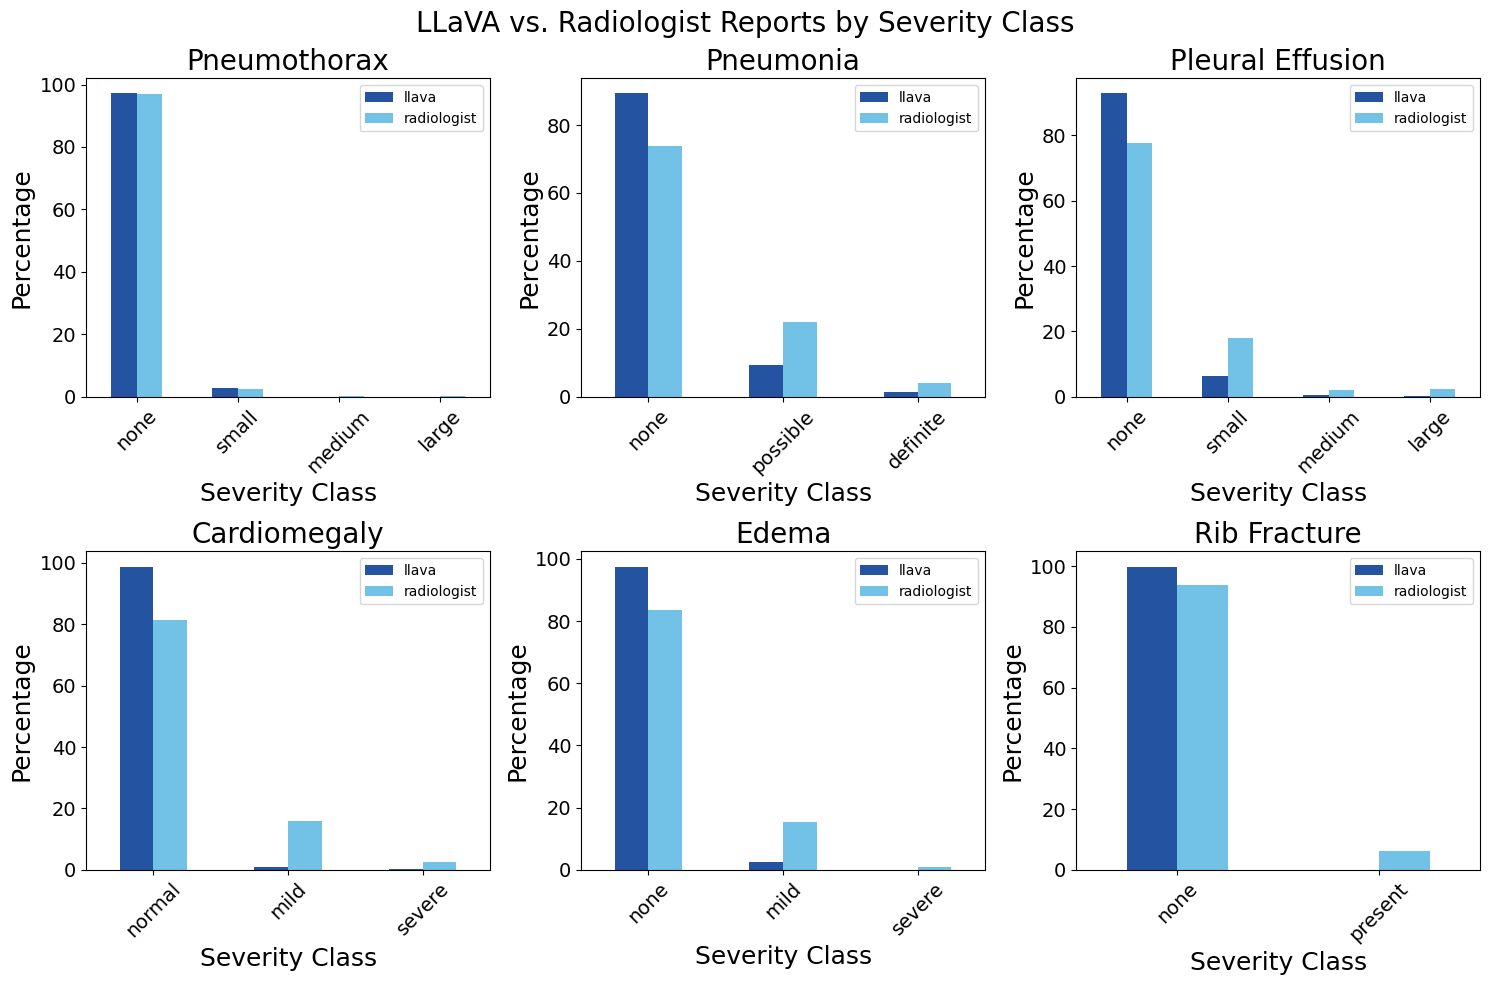

In [340]:
diseases = {
    'Pneumothorax': ['none', 'small', 'medium', 'large'],
    'Pneumonia': ['none', 'possible', 'definite'],
    'Pleural Effusion': ['none', 'small', 'medium', 'large'],
    'Cardiomegaly': ['normal', 'mild', 'severe'],
    'Edema': ['none', 'mild', 'severe'],
    'Rib Fracture': ['none', 'present']
}


def plot_with_f1(df, title, ax, f1):
    # category_counts = df.apply(pd.value_counts).fillna(0)
    category_counts = df.apply(pd.value_counts).fillna(0).apply(lambda x: (x / x.sum()) * 100)
    ordered_counts = pd.DataFrame(index=diseases[title])
    for col in category_counts:
        ordered_counts[col] = category_counts.loc[ordered_counts.index, col]
    
    ordered_counts.plot(kind='bar', ax=ax, color=['#2353a1', '#72c2e8'])    #295191
    ax.set_title(f"{title}", fontsize=20)
    # ax.set_title(f"{title} (F1 Score: {f1:.2f})", fontsize=20)
    ax.set_xlabel('Severity Class', fontsize=18)
    ax.set_ylabel('Percentage', fontsize=18)
    ax.set_xticklabels(ordered_counts.index, rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten() 
fig.subplots_adjust(wspace=0.8, hspace=0.3)

dfs = [('Pneumothorax', Pneumothorax), ('Pneumonia', Pneumonia), 
        ('Pleural Effusion', Pleural_effusion), ('Cardiomegaly', Cardiomegaly), 
        ('Edema', Edema), ('Rib Fracture', Rib_fracture)]

for i, (df_name, df) in enumerate(dfs):
    llava = df.iloc[:, 0]
    radiologist = df.iloc[:, 1]
    f1 = f1_score(radiologist, llava, average='weighted', zero_division=1)
    plot_with_f1(df, df_name, axes[i], f1)

plt.suptitle('LLaVA vs. Radiologist Reports by Severity Class', fontsize=20)
plt.tight_layout()
plt.savefig('../Plots/final_model_bar_plot.png')
plt.show()

In [203]:
(Pleural_effusion['radiologist'] == Pleural_effusion['llava']).mean()

0.7734767025089606

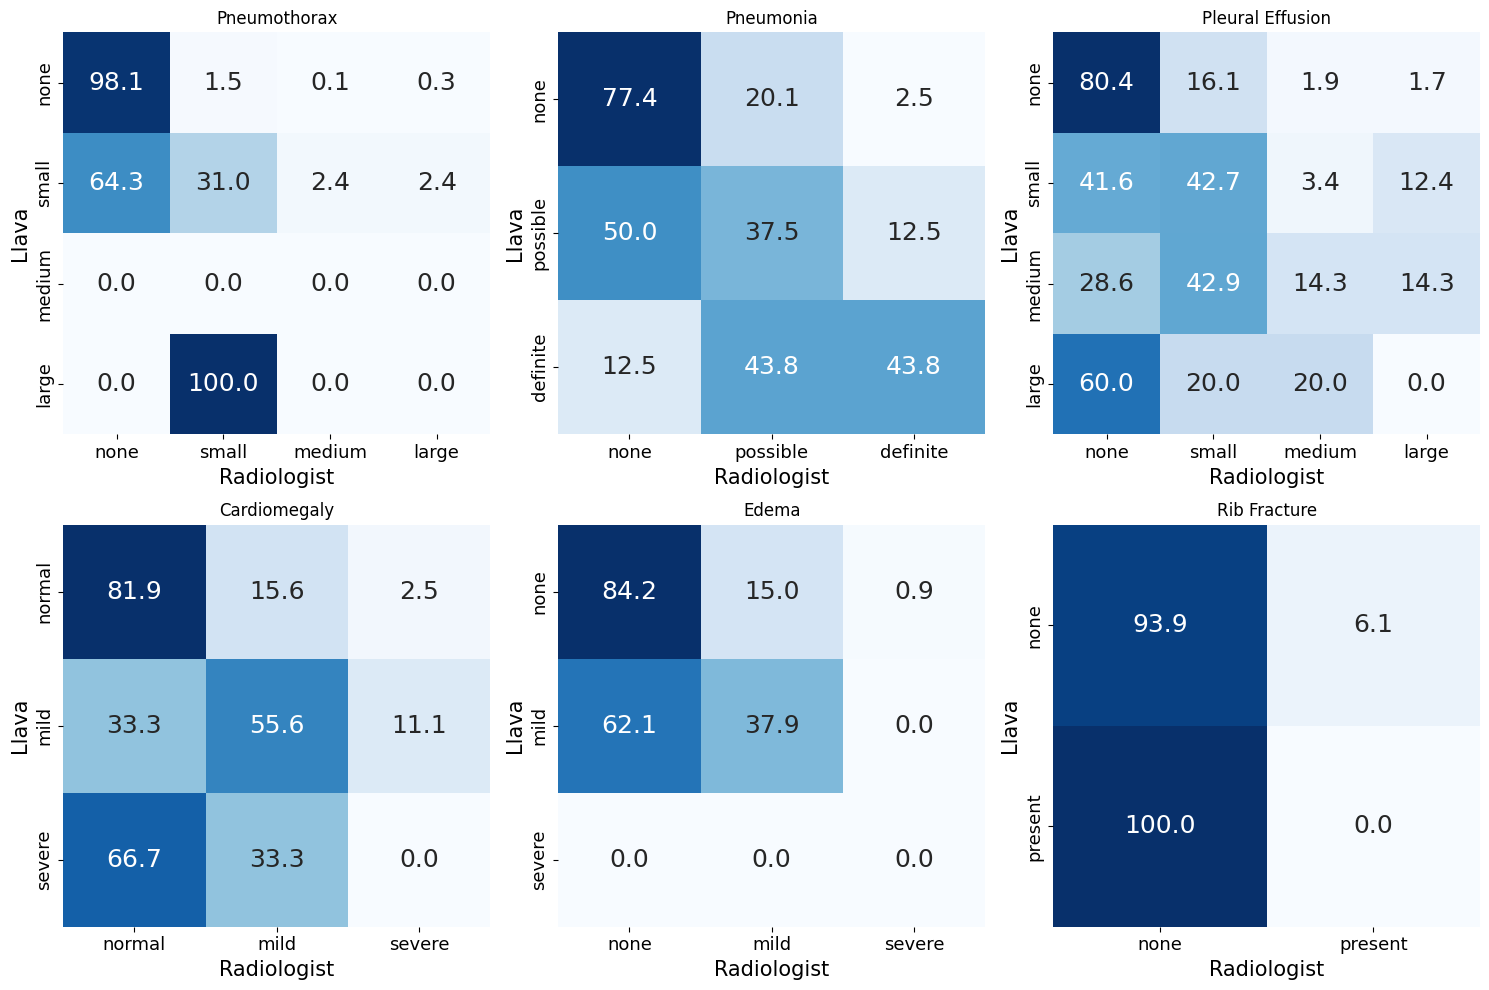

In [328]:
final_model = {}

def plot_confusion_matrix_like(df, title, ax, categories):
    data = pd.crosstab(df.iloc[:, 0], df.iloc[:, 1], rownames=['Llava'], colnames=['Radiologist'], normalize='index')
    data = data.reindex(index=categories, columns=categories, fill_value=0) * 100

    sns.heatmap(data, annot=True, fmt=".1f", ax=ax, cbar=False, cmap="Blues", annot_kws={'size': 18})
    ax.set_title(f"{title}")
    ax.set_xlabel('Radiologist', fontsize=15)
    ax.set_ylabel('Llava', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()
fig.subplots_adjust(wspace=0.8, hspace=0.3)

dfs = [('Pneumothorax', Pneumothorax), ('Pneumonia', Pneumonia), 
       ('Pleural Effusion', Pleural_effusion), ('Cardiomegaly', Cardiomegaly), 
       ('Edema', Edema), ('Rib Fracture', Rib_fracture)]

for i, (df_name, df) in enumerate(dfs):
    llava = df.iloc[:, 0]
    radiologist = df.iloc[:, 1]
    f1 = f1_score(radiologist, llava, labels=diseases[df_name], average='weighted', zero_division=1)
    final_model[df_name] = f1
    if df_name in diseases:
        plot_confusion_matrix_like(df, df_name, axes[i], diseases[df_name])
    else:
        plot_with_f1(df, df_name, axes[i], f1)

# plt.suptitle('LLaVA vs. Radiologist Reports by Severity Class')
plt.tight_layout()
plt.savefig('../Plots/final_model_cf_matrix.png')
plt.show()


In [184]:
df['radiologist_report'].str.lower().str.contains('rib fracture').sum()

55

In [250]:
# F1 scores from model 1
baseline = {'Pneumothorax': 0.9531367957952981,
 'Pneumonia': 0.367811008325187,
 'Pleural Effusion': 0.661134939437385,
 'Cardiomegaly': 0.626891259879878,
 'Edema': 0.5932678970914964,
 'Rib Fracture': 0.6509472862760552}

In [273]:
f1_df = pd.DataFrame()
f1_df['Baseline Model'] = baseline
f1_df['Final Model'] = final_model
f1_df = f1_df.round(3)

pd.set_option('colheader_justify', 'center')
df_styled = f1_df.style.set_properties(**{'text-align': 'center'})
f1_df

,Baseline Model,Final Model
Pneumothorax,0.953,0.964
Pneumonia,0.368,0.684
Pleural Effusion,0.661,0.745
Cardiomegaly,0.627,0.766
Edema,0.593,0.774
Rib Fracture,0.651,0.970


In [274]:
import dataframe_image as dfi
dfi.export(df_styled, '../Plots/f1_table.png')

In [277]:
df = pd.read_csv('raw_parsed.csv')
df = df[['id', 'phonetic_id', 'llava_report', 'radiologist_report']]
df

,id,phonetic_id,llava_report,radiologist_report
0,54059849,Abifel,FINDINGS:\nLungs are well expanded and clear. ...,FINDINGS: Lungs are well expanded and clear....
1,53428634,Aburik,FINDINGS:\nLines and Tubes: Interval placement...,FINDINGS: Lines and Tubes: Right upper ext...
2,53439132,Achoroos,FINDINGS:\nPlease see Impression.\n\nIMPRESSIO...,FINDINGS: Lines and Tubes: None Mediastin...
3,50219723,Ackoofdek,FINDINGS:\nSee impression.\n\nIMPRESSION: Rede...,FINDINGS: \nSee impression\n\nIMPRESSION: ...
4,52165792,Adefoup,FINDINGS:\nUnknown\n\nIMPRESSION: Unknown,FINDINGS: None
...,...,...,...,...
2242,52524739,Yuhidum,FINDINGS:\nDevices: None\nLungs & pleura: The ...,FINDINGS: \n\nSee IMPRESSION.\n\n\n\n\n*\n\...
2243,53657129,Yuhiko,FINDINGS:\nLines and Tubes: Swan-Ganz catheter...,FINDINGS: Lines and Tubes: PICC and pacer ...
2244,53670978,Yutexug,FINDINGS:\nSee impression.\n\nIMPRESSION: 1. N...,FINDINGS: See impression. Signed...
2245,52495793,Zedusi,FINDINGS:\nDevices: None\nLungs & pleura: The ...,FINDINGS: \nDevices: Left anterior chest wa...


In [311]:
print(df['llava_report'][29])

FINDINGS:
Lines and Tubes: Unchanged support devices. Swan-Ganz catheter terminates in the right pulmonary artery.  Mediastinum: The cardiomediastinal silhouette is unchanged.  Lungs: Mild pulmonary edema, similar to prior.  Pleura: No pneumothorax or effusion.  Bones and soft tissues: Unchanged

IMPRESSION: No significant interval change.


In [312]:
print(df['radiologist_report'][29])

FINDINGS:     Lines and Tubes: Unchanged support devices. Swan-Ganz catheter terminates in the right pulmonary artery.  Mediastinum: The cardiomediastinal silhouette is stably enlarged.  Lungs: Mild interstitial edema. Left midlung atelectasis or scarring.  Pleura: No pneumothorax or effusion.  Bones and soft tissues: Unchanged             Signed by: Hahn, Lewis 06/18/2021 08:36:53  IMPRESSION:  IMPRESSION:  No change including mild interstitial edema


In [314]:
df['id'][29]

53760551

In [310]:
Edema[(Edema['radiologist'] != 'none') & (Edema['llava'] != 'none')]

,llava,radiologist
29,mild,mild
86,mild,mild
207,mild,mild
316,mild,mild
574,mild,mild
763,mild,mild
1201,mild,mild
1316,mild,mild
1822,mild,mild
1943,mild,mild
